In [87]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import time

**Grid Generation**

In [88]:
def generate_interior_grid(Nx, Ny, Lx=1.0, Ly=1.0):
    """
    Generates the interior grid points for the domain [0, Lx] x [0, Ly].

    Parameters:
    - Nx (int): Number of interior grid points along x.
    - Ny (int): Number of interior grid points along y.
    - Lx (float): Length of the domain in x-direction.
    - Ly (float): Length of the domain in y-direction.

    Returns:
    - X, Y (2D arrays): Coordinates of interior grid points.
    """
    dx = Lx / (Nx + 1)
    dy = Ly / (Ny + 1)
    x = np.linspace(dx, Lx - dx, Nx)  # Exclude boundaries
    y = np.linspace(dy, Ly - dy, Ny)  # Exclude boundaries
    X, Y = np.meshgrid(x, y, indexing='ij')  # Shape: (Nx, Ny)
    return X, Y

**Matrix Assembly**

In [89]:
def assemble_matrix(Nx, Ny, h):
    """
    Assembles the sparse matrix A for the discrete Poisson equation.

    Parameters:
    - Nx (int): Number of interior points along x.
    - Ny (int): Number of interior points along y.
    - h (float): Grid spacing (assumed uniform in x and y).

    Returns:
    - A (csr_matrix): Sparse matrix representing the discrete Laplacian.
    """
    N = Nx * Ny
    A = lil_matrix((N, N))

    for j in range(Ny):
        for i in range(Nx):
            k = j * Nx + i  # Linear index
            A[k, k] = 4.0 / h**2  # Diagonal entry

            # Left neighbor
            if i > 0:
                A[k, k - 1] = -1.0 / h**2
            # Right neighbor
            if i < Nx - 1:
                A[k, k + 1] = -1.0 / h**2
            # Bottom neighbor
            if j > 0:
                A[k, k - Nx] = -1.0 / h**2
            # Top neighbor
            if j < Ny - 1:
                A[k, k + Nx] = -1.0 / h**2

    return A.tocsr()


**Assembling the Right-Hand Side Vector**

In [90]:
def assemble_rhs(Nx, Ny, X, Y, f_exact, g_func, h, Lx, Ly):
    """
    Assembles the right-hand side vectors b and f considering boundary conditions.

    Parameters:
    - Nx, Ny (int): Number of interior points along x and y.
    - X, Y (2D arrays): Coordinates of interior grid points.
    - f_exact (2D array): Exact source term at interior grid points.
    - g_func (callable): Boundary condition function g(x, y).
    - h (float): Grid spacing.
    - Lx, Ly (float): Domain lengths.

    Returns:
    - b (1D array): Boundary contributions.
    - f (1D array): Source term contributions.
    """
    N = Nx * Ny
    b = np.zeros(N)
    f = np.zeros(N)

    for j in range(Ny):
        for i in range(Nx):
            k = j * Nx + i  # Linear index
            
            f[k] = f_exact[i, j] #/ h**2  # Source term contribution

            # Check if the current point is adjacent to a boundary
            # Left boundary (x=0)
            if i == 0:
                b[k] += g_func(0, Y[i, j]) / h**2
            # Right boundary (x=Lx)
            if i == Nx - 1:
                b[k] += g_func(Lx, Y[i, j]) / h**2
            # Bottom boundary (y=0)
            if j == 0:
                b[k] += g_func(X[i, j], 0) / h**2
            # Top boundary (y=Ly)
            if j == Ny - 1:
                b[k] += g_func(X[i, j], Ly) / h**2

    return b, f


**Solving the Poisson Equation Numerically**

In [91]:
def solve_poisson(Nx, Ny, Lx=1.0, Ly=1.0, f_exact=None, g_func=lambda x, y: 0.0):
    """
    Solves the 2D Poisson equation with Dirichlet boundary conditions.

    Parameters:
    - Nx (int): Number of interior points along x.
    - Ny (int): Number of interior points along y.
    - Lx, Ly (float): Domain lengths.
    - f_exact (2D array): Exact source term at interior grid points.
    - g_func (callable): Boundary condition function g(x, y).

    Returns:
    - X, Y (2D arrays): Coordinates of interior grid points.
    - U (2D array): Numerical solution u at interior grid points.
    - solve_time (float): Time taken to solve the linear system.
    """
    # Generate grid
    X, Y = generate_interior_grid(Nx, Ny, Lx, Ly)
    h = Lx / (Nx + 1)  # Since Nx is the number of interior points

    # Assemble matrix A
    A = assemble_matrix(Nx, Ny, h)

    # Assemble right-hand side vectors b and f
    b, f = assemble_rhs(Nx, Ny, X, Y, f_exact, g_func, h, Lx, Ly)

    # Total right-hand side
    rhs = b + f

    # Solve the linear system
    start_time = time.time()
    u = spsolve(-A, rhs)
    end_time = time.time()
    solve_time = end_time - start_time

    # Reshape solution to 2D grid
    U = u.reshape((Nx, Ny))

    return X, Y, U, solve_time

**Defining the Exact Solution**

In [92]:
def exact_solution(X, Y):
    """
    Exact solution u_ex(x, y) = sin^2(pi x) sin^2(pi y)

    Parameters:
    - X, Y (2D arrays): Coordinates of interior grid points.

    Returns:
    - U_exact (2D array): Exact solution at interior grid points.
    """
    return np.sin(np.pi * X)**2 * np.sin(np.pi * Y)**2

**Defining and Corresponding Right-Hand Side**

In [93]:
def exact_rhs(X, Y):
    """
    Right-hand side function f(x, y) corresponding to the exact solution.

    Parameters:
    - X, Y (2D arrays): Coordinates of interior grid points.

    Returns:
    - f_exact (2D array): Exact source term at interior grid points.
    """
    pi = np.pi
    term1 = 2 * pi**2 * np.cos(2 * pi * X) * (np.sin(pi * Y)**2)
    term2 = 2 * pi**2 * (np.sin(pi * X)**2) * np.cos(2 * pi * Y)
    return term1 + term2

**Computing Relative Error**

In [94]:
def compute_relative_error(U_num, U_exact):
    """
    Computes the relative error in the maximum norm.

    Parameters:
    - U_num (2D array): Numerical solution.
    - U_exact (2D array): Exact solution.

    Returns:
    - rel_error (float): Relative error in maximum norm.
    """
    error = np.abs(U_num - U_exact)
    rel_error = np.max(error) / np.max(np.abs(U_exact))

    #!check this way
    rel_error_2 = np.max(np.abs((U_num -U_exact) / (U_exact + 1e-12)))
    return rel_error

**Convergency**

In [95]:
def perform_convergence_study():
    """
    Performs a convergence study to validate the finite difference solver.
    """

    # Define boundary condition function based on exact solution
    # Since u_ex = 0 on boundaries, homogeneous Dirichlet
    g_homogeneous = lambda x, y: 0.0

    # Grid sizes for convergence study
    # grid_sizes = [10, 20, 40, 100]  # Number of interior points along each axis

    grid_sizes = np.logspace(1.0,3.0, num=10, dtype=int)

    errors = []
    hs = []
    solve_times = []

    for N in grid_sizes:
        Nx, Ny = N, N  # Use square grids for simplicity
        Lx, Ly = 1.0, 1.0

        # Generate grid and compute exact solution
        X, Y = generate_interior_grid(Nx, Ny, Lx, Ly)
        U_exact = exact_solution(X, Y)

        # Compute exact f
        f_exact = exact_rhs(X, Y)

        # Solve Poisson equation numerically
        U_num, solve_time = None, None
        try:
            X_num, Y_num, U_num, solve_time = solve_poisson(
            Nx, Ny, Lx, Ly,
            f_exact=f_exact,
            g_func=g_homogeneous
            )
        except Exception as e:
            print(f"Error solving Poisson equation for grid size {Nx}x{Ny}: {e}")
            continue

        # Compute relative error
        rel_err = compute_relative_error(U_num, U_exact)
        errors.append(rel_err)

        # Compute step size
        h = Lx / (Nx + 1)
        hs.append(h)

        # Record solve time
        solve_times.append(solve_time)

        print(f"Grid Size: {Nx}x{Ny}, h={h:.5f}, Relative Error (Max Norm): {rel_err:.5e}, Solve Time: {solve_time:.4f}s")

    print(np.shape(U_num))
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, U_num, cmap='viridis')
    ax.set_title("Numerical Solution to the Poisson Equation")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()

    # Convergence Plot (Log-Log scale)
    plt.figure(figsize=(8,6))
    plt.loglog(hs, errors, marker='o', linestyle='-', label='Relative Error')
    plt.loglog(hs, [errors[0]*(hs[0]/h)**2 for h in hs], 'b--', label='O(h²) Reference')
    plt.xlabel('Step size (h)')
    plt.ylabel('Maximum Relative Error')
    plt.title('Convergence Plot (Log-Log Scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Convergence Rate Estimation
    rates = []
    for i in range(1, len(errors)):
        rate = np.log(errors[i]/errors[i-1]) / np.log(hs[i]/hs[i-1])
        rates.append(rate)
    print("\nEstimated Convergence Rates:")
    for i, rate in enumerate(rates, 2):
        print(f"From grid size {grid_sizes[i-2]}x{grid_sizes[i-2]} to {grid_sizes[i-1]}x{grid_sizes[i-1]}: Rate ≈ {rate:.2f}")

    # Solve Time Plot
    plt.figure(figsize=(8,6))
    plt.loglog(hs, solve_times, marker='s', linestyle='-', color='r', label='Solve Time')
    plt.xlabel('Step size (h)')
    plt.ylabel('Solve Time (s)')
    plt.title('Solve Time vs. Step Size (Log-Log Scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

**Validation**

Grid Size: 10x10, h=0.09091, Relative Error (Max Norm): 2.76383e-02, Solve Time: 0.0008s
Grid Size: 16x16, h=0.05882, Relative Error (Max Norm): 1.14618e-02, Solve Time: 0.0016s
Grid Size: 27x27, h=0.03571, Relative Error (Max Norm): 4.20685e-03, Solve Time: 0.0022s
Grid Size: 46x46, h=0.02128, Relative Error (Max Norm): 1.49063e-03, Solve Time: 0.0067s
Grid Size: 77x77, h=0.01282, Relative Error (Max Norm): 5.40916e-04, Solve Time: 0.0184s
Grid Size: 129x129, h=0.00769, Relative Error (Max Norm): 1.94689e-04, Solve Time: 0.1627s
Grid Size: 215x215, h=0.00463, Relative Error (Max Norm): 7.05163e-05, Solve Time: 0.6597s
Grid Size: 359x359, h=0.00278, Relative Error (Max Norm): 2.53852e-05, Solve Time: 2.3474s
Grid Size: 599x599, h=0.00167, Relative Error (Max Norm): 9.13857e-06, Solve Time: 9.1237s
Grid Size: 1000x1000, h=0.00100, Relative Error (Max Norm): 3.28330e-06, Solve Time: 83.6180s
(1000, 1000)


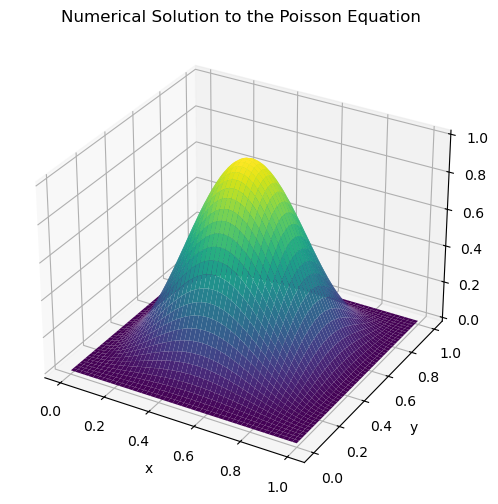

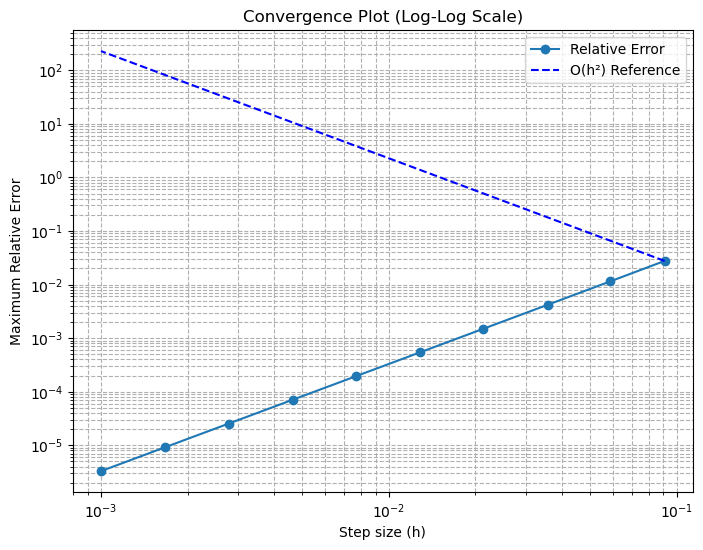


Estimated Convergence Rates:
From grid size 10x10 to 16x16: Rate ≈ 2.02
From grid size 16x16 to 27x27: Rate ≈ 2.01
From grid size 27x27 to 46x46: Rate ≈ 2.00
From grid size 46x46 to 77x77: Rate ≈ 2.00
From grid size 77x77 to 129x129: Rate ≈ 2.00
From grid size 129x129 to 215x215: Rate ≈ 2.00
From grid size 215x215 to 359x359: Rate ≈ 2.00
From grid size 359x359 to 599x599: Rate ≈ 2.00
From grid size 599x599 to 1000x1000: Rate ≈ 2.00


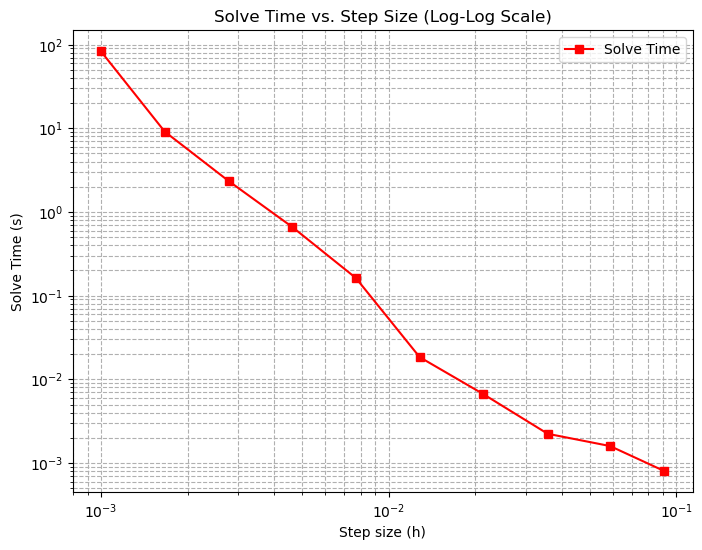

In [96]:
perform_convergence_study()

## 2. Solving the linear system
In this part we will analyze various ways to solve the linear system. We will compare the numerical cost of some direct and iterative methods.
### 2.1. Direct methods

=== Direct Methods Comparison ===
Solving using Dense Matrix Representation...
Dense Solver: Time = 0.8405s, Relative Error = 1.95939e-03

Solving using Sparse Matrix Representation...
Sparse Solver: Time = 0.0072s, Relative Error = 1.95939e-03

Comparison:
Dense Solver Time: 0.8405s
Sparse Solver Time: 0.0072s
Relative Error (Dense): 1.95939e-03
Relative Error (Sparse): 1.95939e-03


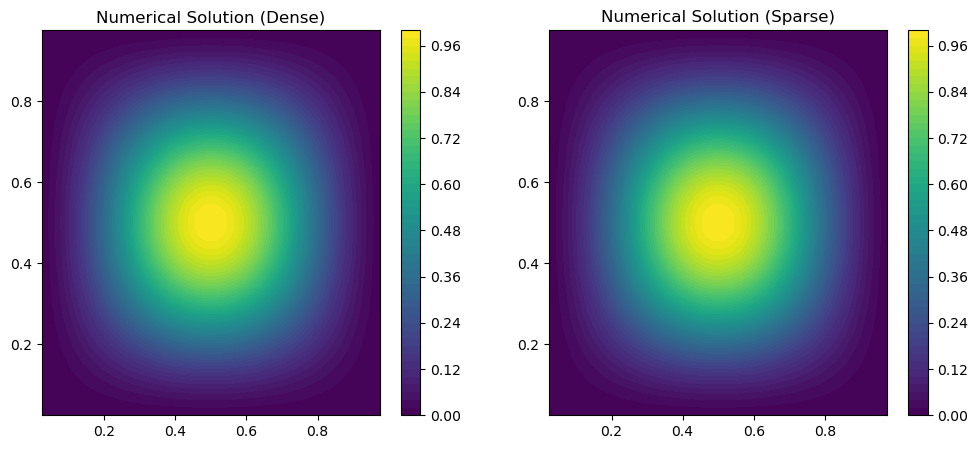


=== Convergence Study for Direct Methods ===

Grid Size: 10x10
Dense Solver: Time = 0.0253s, Relative Error = 2.76383e-02
Sparse Solver: Time = 0.0005s, Relative Error = 2.76383e-02

Grid Size: 20x20
Dense Solver: Time = 0.3014s, Relative Error = 7.49353e-03
Sparse Solver: Time = 0.0017s, Relative Error = 7.49353e-03

Grid Size: 40x40
Dense Solver: Time = 1.1799s, Relative Error = 1.95939e-03
Sparse Solver: Time = 0.0075s, Relative Error = 1.95939e-03

Grid Size: 80x80


Dense Solver: Time = 4.0768s, Relative Error = 5.01579e-04
Sparse Solver: Time = 0.0376s, Relative Error = 5.01579e-04


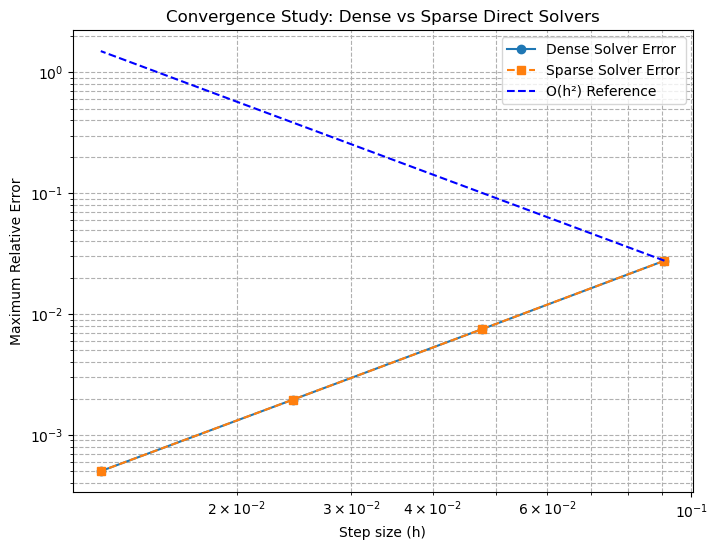

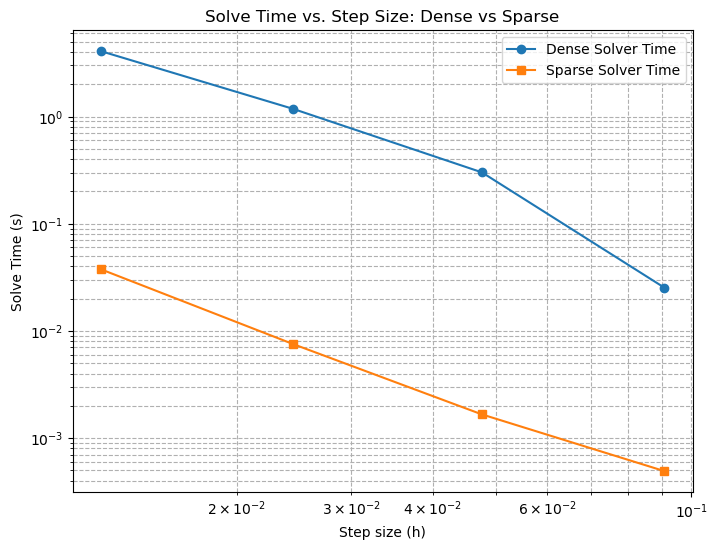


Estimated Convergence Rates for Dense Solver:
From 10x10 to 20x20: Rate ≈ 2.02
From 20x20 to 40x40: Rate ≈ 2.00
From 40x40 to 80x80: Rate ≈ 2.00

Estimated Convergence Rates for Sparse Solver:
From 10x10 to 20x20: Rate ≈ 2.02
From 20x20 to 40x40: Rate ≈ 2.00
From 40x40 to 80x80: Rate ≈ 2.00


In [97]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy.sparse import lil_matrix, kron, eye, diags
from scipy.sparse.linalg import spsolve
import time

def exact_solution(X, Y):
    """Exact solution u(x, y) = sin^2(pi x) sin^2(pi y)."""
    return np.sin(np.pi * X)**2 * np.sin(np.pi * Y)**2

def exact_rhs(X, Y):
    """Right-hand side f(x, y) corresponding to the exact solution."""
    pi = np.pi
    return 2 * pi**2 * (np.cos(2 * pi * X) * (np.sin(pi * Y)**2) + (np.sin(pi * X)**2) * np.cos(2 * pi * Y))

def generate_grid(Nx, Ny, Lx=1.0, Ly=1.0):
    """
    Generates grid points excluding boundaries.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - Lx, Ly: Domain lengths.

    Returns:
    - x, y: 1D arrays of grid points.
    - X, Y: 2D meshgrid arrays.
    - h_x, h_y: Grid spacings.
    """
    h_x = Lx / (Nx + 1)
    h_y = Ly / (Ny + 1)
    x = np.linspace(h_x, Lx - h_x, Nx)
    y = np.linspace(h_y, Ly - h_y, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    return x, y, X, Y, h_x, h_y

def assemble_dense_matrix(Nx, Ny, h_x, h_y):
    """
    Assembles the dense matrix A for the Poisson equation.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - h_x, h_y: Grid spacings.

    Returns:
    - A_dense: Dense numpy array representing the Laplacian.
    """
    N = Nx * Ny
    A_dense = np.zeros((N, N))

    for j in range(Ny):
        for i in range(Nx):
            k = j * Nx + i
            A_dense[k, k] = 4.0 / h_x**2  # Diagonal

            # Left neighbor
            if i > 0:
                A_dense[k, k - 1] = -1.0 / h_x**2
            # Right neighbor
            if i < Nx - 1:
                A_dense[k, k + 1] = -1.0 / h_x**2
            # Bottom neighbor
            if j > 0:
                A_dense[k, k - Nx] = -1.0 / h_y**2
            # Top neighbor
            if j < Ny - 1:
                A_dense[k, k + Nx] = -1.0 / h_y**2

    return -A_dense     #due to a - in formula

def assemble_sparse_matrix(Nx, Ny, h_x, h_y):
    """
    Assembles the sparse matrix A for the Poisson equation using Kronecker products.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - h_x, h_y: Grid spacings.

    Returns:
    - A_sparse: Sparse matrix (CSR format) representing the Laplacian.
    """
    # 1D Laplacian T
    main_diag = 2.0 / h_x**2 * np.ones(Nx)
    off_diag = -1.0 / h_x**2 * np.ones(Nx - 1)
    T = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csr')

    # Identity matrix
    I = eye(Nx, format='csr')

    # 2D Laplacian using Kronecker product
    A_sparse = kron(I, T) + kron(T, I)

    return -A_sparse

def assemble_rhs_vector(Nx, Ny, X, Y, f_func, g_func, h_x, h_y):
    """
    Assembles the RHS vector b considering boundary conditions.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - X, Y: 2D meshgrid arrays.
    - f_func: Source term function f(x, y).
    - g_func: Boundary condition function g(x, y).
    - h_x, h_y: Grid spacings.

    Returns:
    - b: 1D RHS vector.
    """
    N = Nx * Ny
    b = np.zeros(N)

    for j in range(Ny):
        for i in range(Nx):
            k = j * Nx + i
            b[k] = f_func(X[i, j], Y[i, j]) #* h_x**2  # Assuming h_x = h_y

            # Boundary conditions
            # Left boundary (x=0)
            if i == 0:
                b[k] += g_func(0, Y[i, j]) / h_x**2
            # Right boundary (x=Lx)
            if i == Nx - 1:
                b[k] += g_func(1.0, Y[i, j]) / h_x**2
            # Bottom boundary (y=0)
            if j == 0:
                b[k] += g_func(X[i, j], 0) / h_y**2
            # Top boundary (y=Ly)
            if j == Ny - 1:
                b[k] += g_func(X[i, j], 1.0) / h_y**2

    return b

def solve_dense(A_dense, b):
    """
    Solves the linear system using a dense solver.

    Parameters:
    - A_dense: Dense matrix.
    - b: RHS vector.

    Returns:
    - u: Solution vector.
    """
    start_time = time.time()
    u = np.linalg.solve(A_dense, b)
    end_time = time.time()
    solve_time = end_time - start_time
    return u, solve_time

def solve_sparse(A_sparse, b):
    """
    Solves the linear system using a sparse solver.

    Parameters:
    - A_sparse: Sparse matrix.
    - b: RHS vector.

    Returns:
    - u: Solution vector.
    - solve_time: Time taken to solve.
    """
    start_time = time.time()
    u = spsolve(A_sparse, b)
    end_time = time.time()
    solve_time = end_time - start_time
    return u, solve_time

def compute_relative_error(U_num, U_exact):
    """
    Computes the relative error in the maximum norm.

    Parameters:
    - U_num: Numerical solution (1D array).
    - U_exact: Exact solution (1D array).

    Returns:
    - rel_error: Relative error.
    """
    error = np.abs(U_num - U_exact)
    rel_error = np.max(error) / np.max(np.abs(U_exact))
    return rel_error

def perform_direct_methods_comparison():
    """
    Compares dense and sparse direct solvers in terms of computational time and accuracy.
    """
    # Grid parameters
    Nx, Ny = 40, 40  # Adjust as needed
    Lx, Ly = 1.0, 1.0

    # Generate grid
    x, y, X, Y, h_x, h_y = generate_grid(Nx, Ny, Lx, Ly)

    # Compute exact solution and RHS
    U_exact = exact_solution(X, Y)
    f_exact = exact_rhs(X, Y)

    # Define boundary condition function (homogeneous Dirichlet)
    g_homogeneous = lambda x, y: 0.0

    # Assemble RHS vector
    b = assemble_rhs_vector(Nx, Ny, X, Y, exact_rhs, g_homogeneous, h_x, h_y)

    # Assemble Dense Matrix
    A_dense = assemble_dense_matrix(Nx, Ny, h_x, h_y)

    # Solve using Dense Solver
    print("Solving using Dense Matrix Representation...")
    u_dense, time_dense = solve_dense(A_dense, b)
    U_dense = u_dense.reshape((Nx, Ny))
    rel_error_dense = compute_relative_error(u_dense, U_exact.flatten())
    print(f"Dense Solver: Time = {time_dense:.4f}s, Relative Error = {rel_error_dense:.5e}")

    # Assemble Sparse Matrix using Kronecker Product
    A_sparse = assemble_sparse_matrix(Nx, Ny, h_x, h_y)

    # Solve using Sparse Solver
    print("\nSolving using Sparse Matrix Representation...")
    u_sparse, time_sparse = solve_sparse(A_sparse, b)
    U_sparse = u_sparse.reshape((Nx, Ny))
    rel_error_sparse = compute_relative_error(u_sparse, U_exact.flatten())
    print(f"Sparse Solver: Time = {time_sparse:.4f}s, Relative Error = {rel_error_sparse:.5e}")

    # Comparison Results
    print("\nComparison:")
    print(f"Dense Solver Time: {time_dense:.4f}s")
    print(f"Sparse Solver Time: {time_sparse:.4f}s")
    print(f"Relative Error (Dense): {rel_error_dense:.5e}")
    print(f"Relative Error (Sparse): {rel_error_sparse:.5e}")

    # Plotting Numerical vs Exact Solution (Optional)
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.contourf(X, Y, U_dense, 50, cmap='viridis')
    plt.colorbar()
    plt.title('Numerical Solution (Dense)')

    plt.subplot(1, 2, 2)
    plt.contourf(X, Y, U_sparse, 50, cmap='viridis')
    plt.colorbar()
    plt.title('Numerical Solution (Sparse)')

    plt.show()

def perform_convergence_study_direct_methods():
    """
    Performs a convergence study comparing dense and sparse direct solvers.
    """
    grid_sizes = [10, 20, 40, 80]  # Number of interior points along each axis
    errors_dense = []
    errors_sparse = []
    hs = []
    times_dense = []
    times_sparse = []

    for N in grid_sizes:
        print(f"\nGrid Size: {N}x{N}")
        # Generate grid
        x, y, X, Y, h_x, h_y = generate_grid(N, N, 1.0, 1.0)

        # Exact solution and RHS
        U_exact = exact_solution(X, Y)
        f_exact = exact_rhs(X, Y)

        # Boundary condition
        g_homogeneous = lambda x, y: 0.0

        # Assemble RHS
        b = assemble_rhs_vector(N, N, X, Y, exact_rhs, g_homogeneous, h_x, h_y)

        # Dense Matrix and Solver
        A_dense = assemble_dense_matrix(N, N, h_x, h_y)
        start_dense = time.time()
        u_dense, time_dense = solve_dense(A_dense, b)
        end_dense = time.time()
        rel_error_dense = compute_relative_error(u_dense, U_exact.flatten())
        errors_dense.append(rel_error_dense)
        times_dense.append(time_dense)
        print(f"Dense Solver: Time = {time_dense:.4f}s, Relative Error = {rel_error_dense:.5e}")

        # Sparse Matrix and Solver
        A_sparse = assemble_sparse_matrix(N, N, h_x, h_y)
        start_sparse = time.time()
        u_sparse, time_sparse = solve_sparse(A_sparse, b)
        end_sparse = time.time()
        rel_error_sparse = compute_relative_error(u_sparse, U_exact.flatten())
        errors_sparse.append(rel_error_sparse)
        times_sparse.append(time_sparse)
        print(f"Sparse Solver: Time = {time_sparse:.4f}s, Relative Error = {rel_error_sparse:.5e}")

        # Record step size
        h = 1.0 / (N + 1)
        hs.append(h)

    # Convergence Plot
    plt.figure(figsize=(8,6))
    plt.loglog(hs, errors_dense, 'o-', label='Dense Solver Error')
    plt.loglog(hs, errors_sparse, 's--', label='Sparse Solver Error')
    plt.loglog(hs, [errors_dense[0]*(hs[0]/h)**2 for h in hs], 'b--', label='O(h²) Reference')
    plt.xlabel('Step size (h)')
    plt.ylabel('Maximum Relative Error')
    plt.title('Convergence Study: Dense vs Sparse Direct Solvers')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Solve Time Plot
    plt.figure(figsize=(8,6))
    plt.loglog(hs, times_dense, 'o-', label='Dense Solver Time')
    plt.loglog(hs, times_sparse, 's-', label='Sparse Solver Time')
    plt.xlabel('Step size (h)')
    plt.ylabel('Solve Time (s)')
    plt.title('Solve Time vs. Step Size: Dense vs Sparse')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Print Convergence Rates
    print("\nEstimated Convergence Rates for Dense Solver:")
    for i in range(1, len(errors_dense)):
        rate = np.log(errors_dense[i]/errors_dense[i-1]) / np.log(hs[i]/hs[i-1])
        print(f"From {grid_sizes[i-1]}x{grid_sizes[i-1]} to {grid_sizes[i]}x{grid_sizes[i]}: Rate ≈ {rate:.2f}")

    print("\nEstimated Convergence Rates for Sparse Solver:")
    for i in range(1, len(errors_sparse)):
        rate = np.log(errors_sparse[i]/errors_sparse[i-1]) / np.log(hs[i]/hs[i-1])
        print(f"From {grid_sizes[i-1]}x{grid_sizes[i-1]} to {grid_sizes[i]}x{grid_sizes[i]}: Rate ≈ {rate:.2f}")

def main():
    """
    Main function to perform Direct Methods comparison and convergence study.
    """
    print("=== Direct Methods Comparison ===")
    perform_direct_methods_comparison()

    print("\n=== Convergence Study for Direct Methods ===")
    perform_convergence_study_direct_methods()

if __name__ == "__main__":
    main()


### 2.2. Iterative methods
We shall now investigate the performance of some iterative methods

**Common Components for Iterative Methods**

In [98]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from scipy.sparse import lil_matrix, csr_matrix, kron, eye
from scipy.sparse.linalg import spsolve

import time

def generate_grid(Nx, Ny, Lx=1.0, Ly=1.0):
    """
    Generates grid points excluding boundaries.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - Lx, Ly: Domain lengths.

    Returns:
    - x, y: 1D arrays of grid points.
    - X, Y: 2D meshgrid arrays.
    - h_x, h_y: Grid spacings.
    """
    h_x = Lx / (Nx + 1)
    h_y = Ly / (Ny + 1)
    x = np.linspace(h_x, Lx - h_x, Nx)
    y = np.linspace(h_y, Ly - h_y, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    return x, y, X, Y, h_x, h_y

def exact_solution(X, Y):
    """Exact solution u(x, y) = sin^2(pi x) sin^2(pi y)."""
    return np.sin(np.pi * X)**2 * np.sin(np.pi * Y)**2

def exact_rhs(X, Y):
    """Right-hand side f(x, y) corresponding to the exact solution."""
    pi = np.pi
    return 2 * pi**2 * (np.cos(2 * pi * X) * (np.sin(pi * Y)**2) + (np.sin(pi * X)**2) * np.cos(2 * pi * Y))

def assemble_sparse_matrix(Nx, Ny, h_x, h_y):
    """
    Assembles the sparse matrix A for the Poisson equation using Kronecker products.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - h_x, h_y: Grid spacings.

    Returns:
    - A_sparse: Sparse matrix (CSR format) representing the Laplacian.
    """
    # 1D Laplacian T
    main_diag = 2.0 / h_x**2 * np.ones(Nx)
    off_diag = -1.0 / h_x**2 * np.ones(Nx - 1)
    T = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csr')

    # Identity matrix
    I = eye(Nx, format='csr')

    # 2D Laplacian using Kronecker product
    A_sparse = kron(I, T) + kron(T, I)

    return -A_sparse

def assemble_rhs_vector(Nx, Ny, X, Y, f_func, g_func, h_x, h_y):
    """
    Assembles the RHS vector b considering boundary conditions.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - X, Y: 2D meshgrid arrays.
    - f_func: Source term function f(x, y).
    - g_func: Boundary condition function g(x, y).
    - h_x, h_y: Grid spacings.

    Returns:
    - b: 1D RHS vector.
    """
    N = Nx * Ny
    b = np.zeros(N)

    for j in range(Ny):
        for i in range(Nx):
            k = j * Nx + i  # Linear index
            b[k] = f_func(X[i, j], Y[i, j])  #* h_x**2  # Assuming h_x = h_y

            # Boundary conditions
            # Left boundary (x=0)
            if i == 0:
                b[k] += g_func(0, Y[i, j]) / h_x**2
            # Right boundary (x=Lx)
            if i == Nx - 1:
                b[k] += g_func(1.0, Y[i, j]) / h_x**2
            # Bottom boundary (y=0)
            if j == 0:
                b[k] += g_func(X[i, j], 0) / h_y**2
            # Top boundary (y=Ly)
            if j == Ny - 1:
                b[k] += g_func(X[i, j], 1.0) / h_y**2

    return b

def solve_poisson_direct(A, b, method='dense'):
    """
    Solves the Poisson equation using a direct solver.

    Parameters:
    - A: Matrix (dense or sparse).
    - b: RHS vector.
    - method: 'dense' or 'sparse'.

    Returns:
    - u: Solution vector.
    - solve_time: Time taken to solve.
    """
    start_time = time.time()
    if method == 'dense':
        u = np.linalg.solve(A, b)
    elif method == 'sparse':
        u = spsolve(A, b)
    else:
        raise ValueError("Method must be 'dense' or 'sparse'")
    end_time = time.time()
    solve_time = end_time - start_time
    return u, solve_time


 Implementing the **Jacobi** and **Gauss-Seidel** Methods

In [99]:
def jacobi_method(A_sparse, b, tol=1e-6, max_iterations=1000):
    """
    Implements the Jacobi iterative method.

    Parameters:
    - A_sparse: Sparse matrix A in CSR format.
    - b: RHS vector.
    - tol: Tolerance for convergence.
    - max_iterations: Maximum number of iterations.

    Returns:
    - u: Solution vector.
    - iterations: Number of iterations performed.
    - residuals: List of residual norms at each iteration.
    """
    D = A_sparse.diagonal()
    R = A_sparse - diags(D, offsets=0)
    D_inv = 1.0 / D
    u = np.zeros_like(b)
    residuals = []

    for it in range(max_iterations):
        u_new = D_inv * (b - R.dot(u))
        residual = np.linalg.norm(b - A_sparse.dot(u_new), ord=np.inf)
        residuals.append(residual)
        if residual < tol:
            return u_new, it+1, residuals
        u = u_new

    print("Jacobi method did not converge within the maximum number of iterations.")
    return u, it+1, residuals

def gauss_seidel_method(A_sparse, b, tol=1e-6, max_iterations=1000):
    """
    Implements the Gauss-Seidel iterative method.

    Parameters:
    - A_sparse: Sparse matrix A in CSR format.
    - b: RHS vector.
    - tol: Tolerance for convergence.
    - max_iterations: Maximum number of iterations.

    Returns:
    - u: Solution vector.
    - iterations: Number of iterations performed.
    - residuals: List of residual norms at each iteration.
    """
    u = np.zeros_like(b)
    residuals = []
    N = len(b)

    A_csr = A_sparse.tocsr()

    for it in range(max_iterations):
        for i in range(N):
            row_start = A_csr.indptr[i]
            row_end = A_csr.indptr[i+1]
            Ai = A_csr.indices[row_start:row_end]
            Av = A_csr.data[row_start:row_end]

            sum_ = 0.0
            diag = 0.0
            for idx, col in enumerate(Ai):
                if col == i:
                    diag = Av[idx]
                else:
                    sum_ += Av[idx] * u[col]
            u[i] = (b[i] - sum_) / diag

        residual = np.linalg.norm(b - A_sparse.dot(u), ord=np.inf)
        residuals.append(residual)
        if residual < tol:
            return u, it+1, residuals

    print("Gauss-Seidel method did not converge within the maximum number of iterations.")
    return u, it+1, residuals


Validation with a Small Test Case

In [100]:
def validate_iterative_methods():
    """
    Validates the Jacobi and Gauss-Seidel implementations using a small test case.
    """
    # Small grid size for validation
    Nx, Ny = 4, 4
    Lx, Ly = 1.0, 1.0

    # Generate grid
    x, y, X, Y, h_x, h_y = generate_grid(Nx, Ny, Lx, Ly)

    # Exact solution and RHS
    U_exact = exact_solution(X, Y)
    f_exact = exact_rhs(X, Y)

    # Boundary condition
    g_homogeneous = lambda x, y: 0.0

    # Assemble RHS vector
    b = assemble_rhs_vector(Nx, Ny, X, Y, exact_rhs, g_homogeneous, h_x, h_y)

    # Assemble Sparse Matrix
    A_sparse = assemble_sparse_matrix(Nx, Ny, h_x, h_y)

    # Flatten exact solution for comparison
    U_exact_flat = U_exact.flatten()

    # Jacobi Method
    u_jacobi, iter_jacobi, res_jacobi = jacobi_method(A_sparse, b, tol=1e-6, max_iterations=1000)
    error_jacobi = compute_relative_error(u_jacobi, U_exact_flat)
    print(f"\nJacobi Method:\nIterations: {iter_jacobi}, Relative Error: {error_jacobi:.5e}")

    # Gauss-Seidel Method
    u_gs, iter_gs, res_gs = gauss_seidel_method(A_sparse, b, tol=1e-6, max_iterations=1000)
    error_gs = compute_relative_error(u_gs, U_exact_flat)
    print(f"Gauss-Seidel Method:\nIterations: {iter_gs}, Relative Error: {error_gs:.5e}")

    # Plot residuals
    plt.figure(figsize=(10,5))
    plt.semilogy(range(1, iter_jacobi+1), res_jacobi, label='Jacobi')
    plt.semilogy(range(1, iter_gs+1), res_gs, label='Gauss-Seidel')
    plt.xlabel('Iteration')
    plt.ylabel('Residual (log scale)')
    plt.title('Convergence of Iterative Methods')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Compare numerical and exact solutions
    U_jacobi = u_jacobi.reshape((Nx, Ny))
    U_gs = u_gs.reshape((Nx, Ny))

    fig, axs = plt.subplots(1, 3, figsize=(18,5))

    cs1 = axs[0].contourf(X, Y, U_exact, 20, cmap='viridis')
    axs[0].set_title('Exact Solution')
    fig.colorbar(cs1, ax=axs[0])

    cs2 = axs[1].contourf(X, Y, U_jacobi, 20, cmap='viridis')
    axs[1].set_title('Jacobi Solution')
    fig.colorbar(cs2, ax=axs[1])

    cs3 = axs[2].contourf(X, Y, U_gs, 20, cmap='viridis')
    axs[2].set_title('Gauss-Seidel Solution')
    fig.colorbar(cs3, ax=axs[2])

    plt.show()


**Implementing the SOR Method**

In [101]:
def sor_method(A_sparse, b, omega, tol=1e-6, max_iterations=1000):
    """
    Implements the Successive Over-Relaxation (SOR) method.

    Parameters:
    - A_sparse: Sparse matrix A in CSR format.
    - b: RHS vector.
    - omega: Relaxation parameter.
    - tol: Tolerance for convergence.
    - max_iterations: Maximum number of iterations.

    Returns:
    - u: Solution vector.
    - iterations: Number of iterations performed.
    - residuals: List of residual norms at each iteration.
    """
    u = np.zeros_like(b)
    residuals = []
    N = len(b)
    A_csr = A_sparse.tocsr()

    for it in range(max_iterations):
        for i in range(N):
            row_start = A_csr.indptr[i]
            row_end = A_csr.indptr[i+1]
            Ai = A_csr.indices[row_start:row_end]
            Av = A_csr.data[row_start:row_end]

            sum_ = 0.0
            diag = 0.0
            for idx, col in enumerate(Ai):
                if col == i:
                    diag = Av[idx]
                else:
                    sum_ += Av[idx] * u[col]
            u_new = (1 - omega) * u[i] + (omega / diag) * (b[i] - sum_)
            u[i] = u_new

        residual = np.linalg.norm(b - A_sparse.dot(u), ord=np.inf)
        residuals.append(residual)
        if residual < tol:
            return u, it+1, residuals

    print("SOR method did not converge within the maximum number of iterations.")
    return u, it+1, residuals


**Finding the Optimal ω**

In [102]:
def find_optimal_omega(A_sparse, b, omegas, tol=1e-6, max_iterations=1000):
    """
    Finds the optimal relaxation parameter omega for the SOR method.

    Parameters:
    - A_sparse: Sparse matrix A in CSR format.
    - b: RHS vector.
    - omegas: List or array of omega values to test.
    - tol: Tolerance for convergence.
    - max_iterations: Maximum number of iterations.

    Returns:
    - optimal_omega: Omega with the least number of iterations.
    - omega_iterations: Dictionary mapping omega to iterations.
    """
    omega_iterations = {}
    for omega in omegas:
        _, iter_count, _ = sor_method(A_sparse, b, omega, tol, max_iterations)
        omega_iterations[omega] = iter_count
        print(f"Omega: {omega:.2f}, Iterations: {iter_count}")

    # Find omega with minimum iterations
    optimal_omega = min(omega_iterations, key=omega_iterations.get)
    return optimal_omega, omega_iterations


**Iterations vs. Omega**

In [103]:
def plot_iterations_vs_omega(omega_iterations):
    """
    Plots the number of iterations against omega values.

    Parameters:
    - omega_iterations: Dictionary mapping omega to iterations.
    """
    omegas = list(omega_iterations.keys())
    iterations = list(omega_iterations.values())

    plt.figure(figsize=(8,6))
    plt.plot(omegas, iterations, 'o-', color='purple')
    plt.xlabel('Relaxation Parameter (omega)')
    plt.ylabel('Number of Iterations')
    plt.title('SOR: Iterations vs. Relaxation Parameter')
    plt.grid(True)
    plt.show()


In [104]:
def optimize_sor_parameter():
    """
    Optimizes the relaxation parameter omega for the SOR method.
    """
    # Grid parameters
    Nx, Ny = 40, 40
    Lx, Ly = 1.0, 1.0

    # Generate grid
    x, y, X, Y, h_x, h_y = generate_grid(Nx, Ny, Lx, Ly)

    # Exact solution and RHS
    U_exact = exact_solution(X, Y)
    f_exact = exact_rhs(X, Y)

    # Boundary condition
    g_homogeneous = lambda x, y: 0.0

    # Assemble RHS vector
    b = assemble_rhs_vector(Nx, Ny, X, Y, exact_rhs, g_homogeneous, h_x, h_y)

    # Assemble Sparse Matrix using Kronecker Product
    A_sparse = assemble_sparse_matrix(Nx, Ny, h_x, h_y)

    # Define range of omega to test
    omegas = np.arange(1.0, 2.0, 0.05)

    # Find optimal omega
    print("Finding optimal omega for SOR method...")
    optimal_omega, omega_iterations = find_optimal_omega(A_sparse, b, omegas, tol=1e-6, max_iterations=1000)
    print(f"\nOptimal Omega: {optimal_omega:.2f}, with {omega_iterations[optimal_omega]} iterations.")

    # Plot iterations vs omega
    plot_iterations_vs_omega(omega_iterations)

    # Plot residuals for optimal omega
    print(f"\nRunning SOR with optimal omega = {optimal_omega:.2f}")
    u_sor, iter_sor, res_sor = sor_method(A_sparse, b, optimal_omega, tol=1e-6, max_iterations=1000)
    print(f"SOR Method: Iterations = {iter_sor}, Relative Error = {compute_relative_error(u_sor, U_exact.flatten()):.5e}")

    # Plot residuals
    plt.figure(figsize=(10,5))
    plt.semilogy(range(1, iter_sor+1), res_sor, label=f'SOR (omega={optimal_omega:.2f})')
    plt.xlabel('Iteration')
    plt.ylabel('Residual (log scale)')
    plt.title('Convergence of SOR Method')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    return optimal_omega, iter_sor


In [105]:
def compare_iterative_methods():
    """
    Compares Jacobi, Gauss-Seidel, and SOR methods in terms of residual convergence.
    """
    # Grid parameters
    Nx, Ny = 40, 40
    Lx, Ly = 1.0, 1.0

    # Generate grid
    x, y, X, Y, h_x, h_y = generate_grid(Nx, Ny, Lx, Ly)

    # Exact solution and RHS
    U_exact = exact_solution(X, Y)
    f_exact = exact_rhs(X, Y)

    # Boundary condition
    g_homogeneous = lambda x, y: 0.0

    # Assemble RHS vector
    b = assemble_rhs_vector(Nx, Ny, X, Y, exact_rhs, g_homogeneous, h_x, h_y)

    # Assemble Sparse Matrix
    A_sparse = assemble_sparse_matrix(Nx, Ny, h_x, h_y)

    # Jacobi Method
    print("Running Jacobi Method...")
    u_jacobi, iter_jacobi, res_jacobi = jacobi_method(A_sparse, b, tol=1e-6, max_iterations=1000)
    print(f"Jacobi Method: Iterations = {iter_jacobi}, Relative Error = {compute_relative_error(u_jacobi, U_exact.flatten()):.5e}")

    # Gauss-Seidel Method
    print("\nRunning Gauss-Seidel Method...")
    u_gs, iter_gs, res_gs = gauss_seidel_method(A_sparse, b, tol=1e-6, max_iterations=1000)
    print(f"Gauss-Seidel Method: Iterations = {iter_gs}, Relative Error = {compute_relative_error(u_gs, U_exact.flatten()):.5e}")

    # SOR Method
    optimal_omega, iter_sor = optimize_sor_parameter()
    u_sor, iter_sor_actual, res_sor = sor_method(A_sparse, b, optimal_omega, tol=1e-6, max_iterations=1000)
    rel_error_sor = compute_relative_error(u_sor, U_exact.flatten())
    print(f"SOR Method: Iterations = {iter_sor_actual}, Relative Error = {rel_error_sor:.5e}")

    # Plot residuals
    plt.figure(figsize=(10,6))
    plt.semilogy(range(1, iter_jacobi+1), res_jacobi, label='Jacobi')
    plt.semilogy(range(1, iter_gs+1), res_gs, label='Gauss-Seidel')
    plt.semilogy(range(1, iter_sor_actual+1), res_sor, label=f'SOR (omega={optimal_omega:.2f})')
    plt.xlabel('Iteration')
    plt.ylabel('Residual (log scale)')
    plt.title('Convergence of Iterative Methods')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Reshape solutions for plotting
    U_jacobi = u_jacobi.reshape((Nx, Ny))
    U_gs = u_gs.reshape((Nx, Ny))
    U_sor = u_sor.reshape((Nx, Ny))
    
    # Create 3D Surface Plots
    fig = plt.figure(figsize=(20, 15))

    # Exact Solution
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, Y, U_exact, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax1.set_title('Exact Solution')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u(x, y)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

    # Jacobi Solution
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, Y, U_jacobi, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax2.set_title('Jacobi Method Solution')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('u(x, y)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    # Gauss-Seidel Solution
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    surf3 = ax3.plot_surface(X, Y, U_gs, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax3.set_title('Gauss-Seidel Method Solution')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('u(x, y)')
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

    # SOR Solution
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    surf4 = ax4.plot_surface(X, Y, U_sor, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax4.set_title(f'SOR Method Solution (omega={optimal_omega:.2f})')
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    ax4.set_zlabel('u(x, y)')
    fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=10)

    plt.tight_layout()
    plt.show()


=== Direct Methods Comparison ===
Solving using Dense Matrix Representation...
Dense Solver: Time = 0.7235s, Relative Error = 1.95939e-03

Solving using Sparse Matrix Representation...
Sparse Solver: Time = 0.0073s, Relative Error = 1.95939e-03

Comparison:
Dense Solver Time: 0.7235s
Sparse Solver Time: 0.0073s
Relative Error (Dense): 1.95939e-03
Relative Error (Sparse): 1.95939e-03


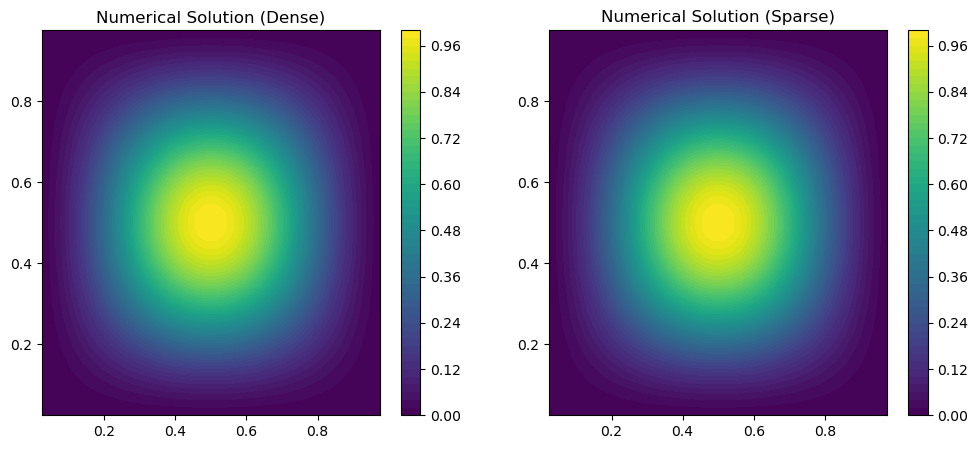

In [106]:
print("=== Direct Methods Comparison ===")
perform_direct_methods_comparison()


Grid Size: 10x10
Dense Solver: Time = 0.0420s, Relative Error = 2.76383e-02
Sparse Solver: Time = 0.0035s, Relative Error = 2.76383e-02

Grid Size: 20x20
Dense Solver: Time = 0.2685s, Relative Error = 7.49353e-03
Sparse Solver: Time = 0.0054s, Relative Error = 7.49353e-03

Grid Size: 40x40
Dense Solver: Time = 1.3878s, Relative Error = 1.95939e-03
Sparse Solver: Time = 0.0072s, Relative Error = 1.95939e-03

Grid Size: 80x80
Dense Solver: Time = 3.8491s, Relative Error = 5.01579e-04
Sparse Solver: Time = 0.0268s, Relative Error = 5.01579e-04


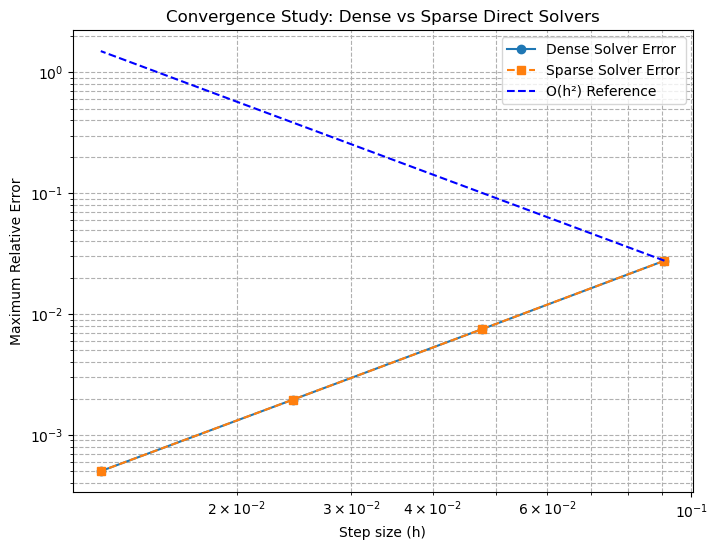

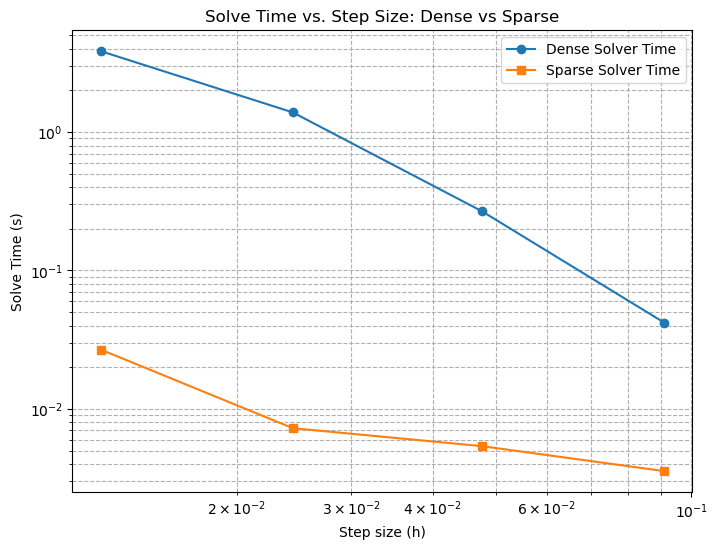


Estimated Convergence Rates for Dense Solver:
From 10x10 to 20x20: Rate ≈ 2.02
From 20x20 to 40x40: Rate ≈ 2.00
From 40x40 to 80x80: Rate ≈ 2.00

Estimated Convergence Rates for Sparse Solver:
From 10x10 to 20x20: Rate ≈ 2.02
From 20x20 to 40x40: Rate ≈ 2.00
From 40x40 to 80x80: Rate ≈ 2.00


In [107]:
perform_convergence_study_direct_methods()


Jacobi Method:
Iterations: 78, Relative Error: 1.42674e-01
Gauss-Seidel Method:
Iterations: 40, Relative Error: 1.42674e-01


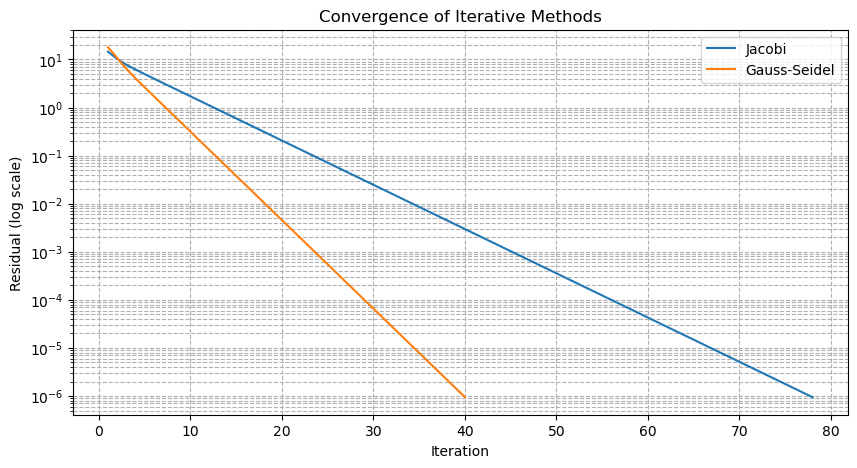

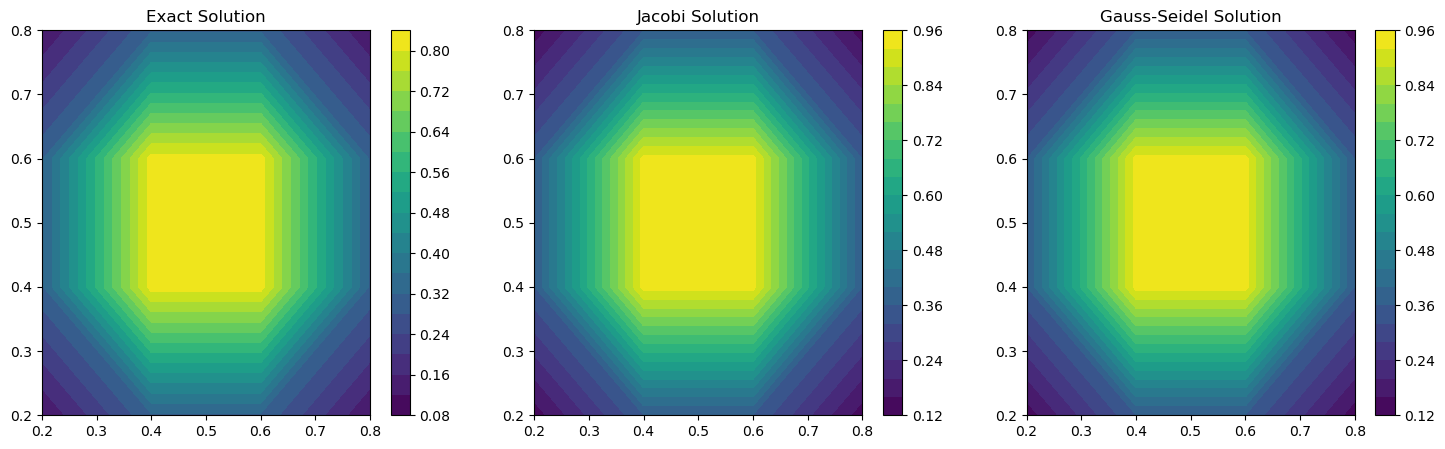

In [108]:
validate_iterative_methods()

Running Jacobi Method...
Jacobi method did not converge within the maximum number of iterations.
Jacobi Method: Iterations = 1000, Relative Error = 3.63185e-02

Running Gauss-Seidel Method...
Gauss-Seidel method did not converge within the maximum number of iterations.
Gauss-Seidel Method: Iterations = 1000, Relative Error = 5.89119e-04
Finding optimal omega for SOR method...
SOR method did not converge within the maximum number of iterations.
Omega: 1.00, Iterations: 1000
SOR method did not converge within the maximum number of iterations.
Omega: 1.05, Iterations: 1000
SOR method did not converge within the maximum number of iterations.
Omega: 1.10, Iterations: 1000
SOR method did not converge within the maximum number of iterations.
Omega: 1.15, Iterations: 1000
SOR method did not converge within the maximum number of iterations.
Omega: 1.20, Iterations: 1000
SOR method did not converge within the maximum number of iterations.
Omega: 1.25, Iterations: 1000
SOR method did not converge

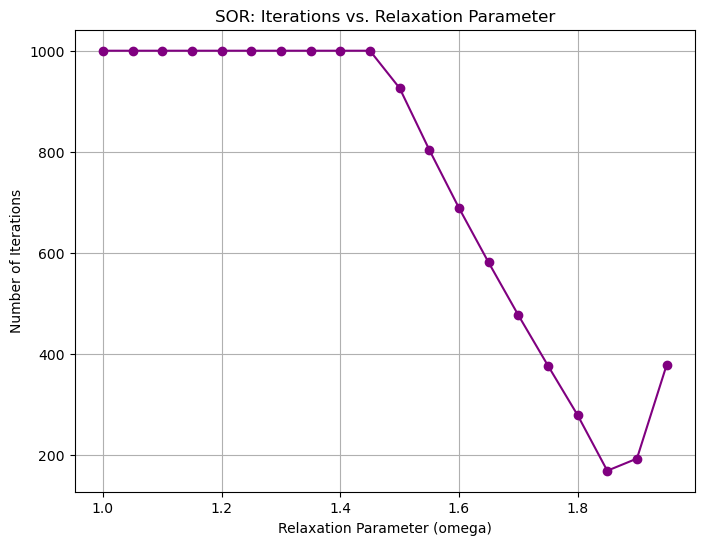


Running SOR with optimal omega = 1.85
SOR Method: Iterations = 169, Relative Error = 1.95938e-03


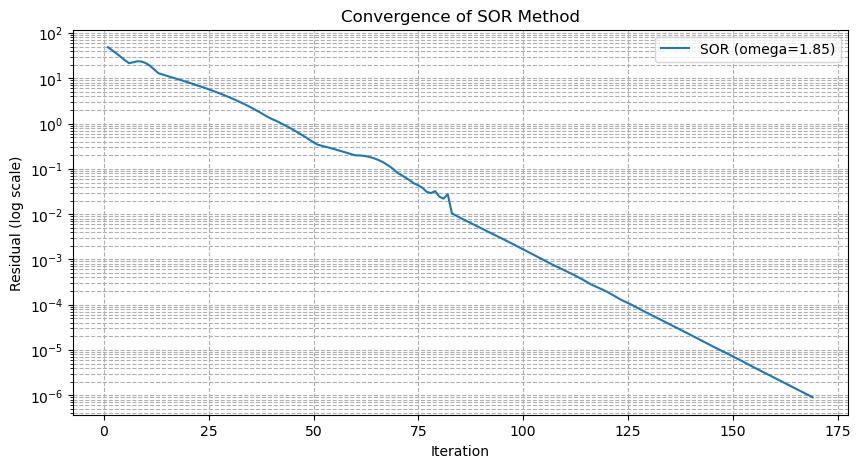

SOR Method: Iterations = 169, Relative Error = 1.95938e-03


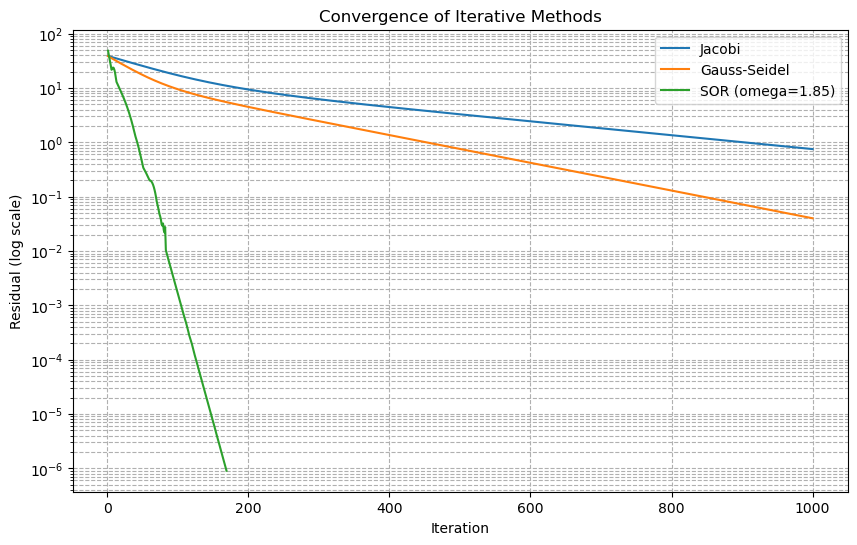

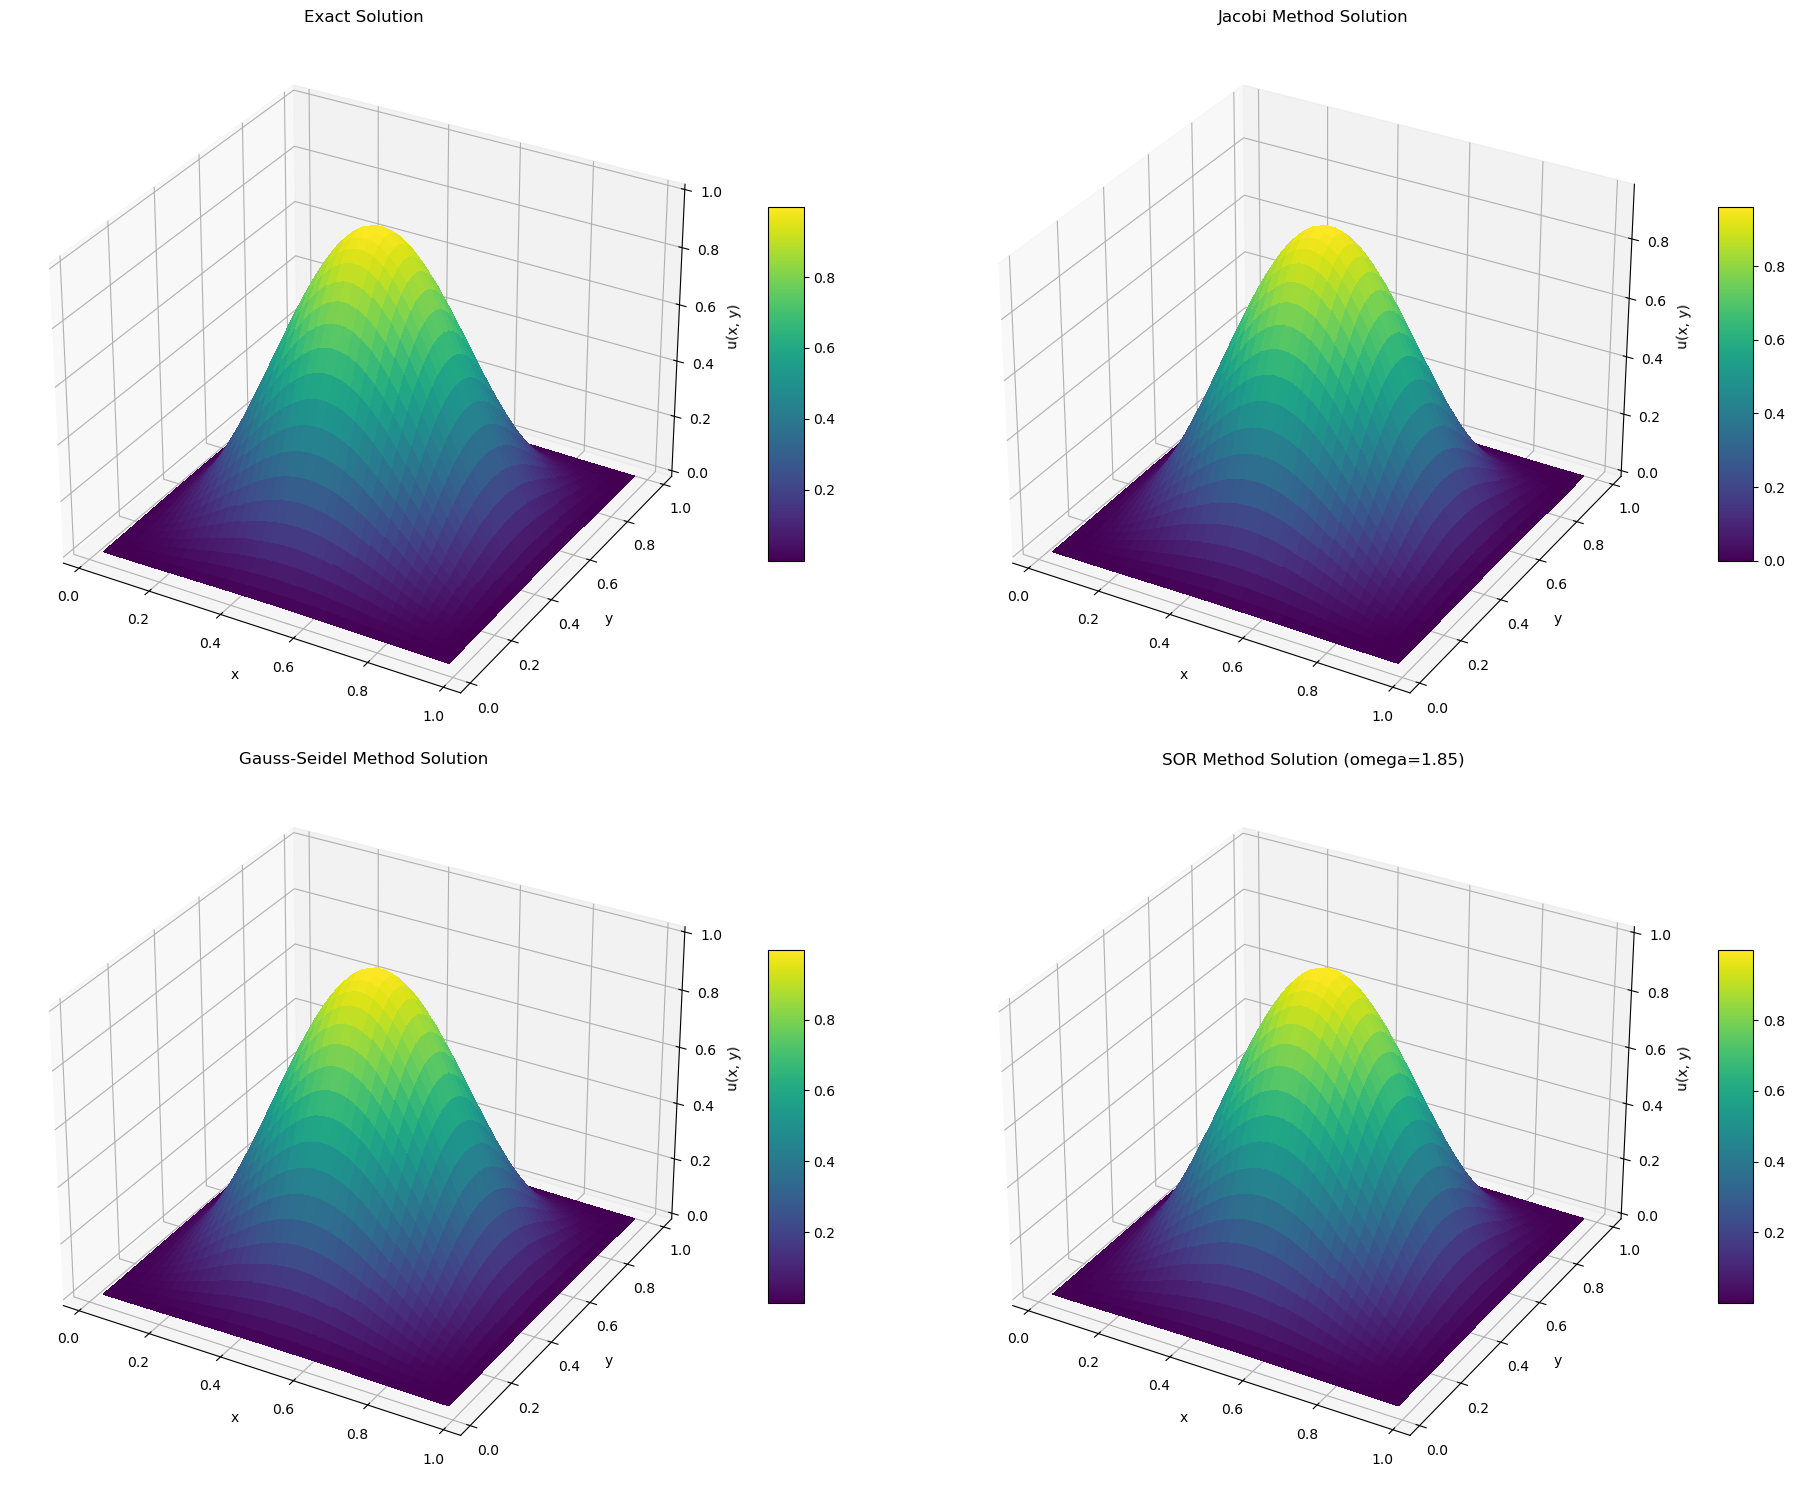

In [109]:
compare_iterative_methods()

#### Extensions to the solver

**Implementing a higher order finite difference formula**

Here, we consider a fourth-order problem and compare it with the result of our second-order problem

Please look at the related notebook to see the comparison of the 2nd and 4th order solver